# import

In [1]:
import numpy as np
import dimod
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
import minorminer
import minorminer.layout as mml
%matplotlib inline
import dwave.inspector
import matplotlib as mpl
import math
from datetime import datetime
from pathlib import Path  
import pandas as pd
import os

In [2]:

from dwave.system import DWaveSampler

# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# functions

In [3]:
def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

In [4]:
def RegsToTups(all_regs):
    alledges=[]
    allnodes=[]
    for arr in all_regs:
        list0=arr[0]
        list1=arr[1]
        for i in range(len(list0)):
            qubit0=int(list0[i])
            qubit1=int(list1[i])
            alledges.append((qubit0,qubit1))
            allnodes.append(qubit0)
            allnodes.append(qubit1)
    allnodes=set(allnodes)
    return alledges,allnodes

# Tiling patterns

How to tile the different $J_{\Box}$? The challenge then becomes to stich the (even) or (odd) parity encoding next to the other one. For that purpose, a square lattice is divided as a checkerboard lattice with A and B square cells (A and B refer to the S sublattice). Within each of these cells, a P=+1 or -1 cell can sit. We need that cells of (P,S) = (1,A) be compatible with (1, B) and (-1, B), and (-1,A) needs to be compatible with (1,B) and (-1, B). Importantly, (1,S) does not need to be compatible with (-1, S). 

Below, the different A and B encodings are shown.

#### Plot checkboard pattern:

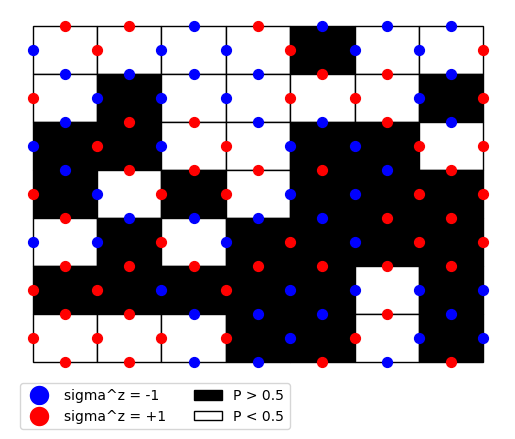

In [6]:
from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Lx = 7; Ly = 7;
#this is the plaquette values
ary = np.random.rand(Lx,Ly)
#random_colors = np.random.randint(0, 2, (Lx, Ly))
#this is the individual qubit values (at nodes)
node_values = np.random.randint(0, 2, (Lx+1, Ly+1))

ybond_qubit = np.random.randint(0, 2, (Lx, Ly+1))
xbond_qubit = np.random.randint(0, 2, (Lx+1, Ly))

cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
#tb = Table(ax, bbox = [0,0,(Lx)/(Lx+1),Ly/(Ly+1)])



# for ix in range(Lx +1):
#     for iy in range(Ly +1):
#         ax.scatter([ix], [iy], s=50, color = node_colors[node_values[ix, iy]])
#ax.scatter([-5], [1], s=50, color = 'red')

# n_rows, n_cols = ybond_qubit.shape
# for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
#     ax.scatter([row_idx/n_rows], [1.2*col_idx/n_cols], s=50, color = node_colors[cell_val])
for (row_idx, col_idx), cell_val in np.ndenumerate(ybond_qubit):
    ax.scatter([0.5 + row_idx], [col_idx], s=50, color = node_colors[cell_val])

for (row_idx, col_idx), cell_val in np.ndenumerate(xbond_qubit):
    ax.scatter([row_idx], [0.5+ col_idx], s=50, color = node_colors[cell_val])


#tb = Table(ax, bbox = [0.0, 0.045, 1.0, 1.0])
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    if show_text:
        text_in = fmt % cell_val
    else:
        text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        text=text_in,
        loc="center",
        facecolor=cell_colors[color_code],
    )
    tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

ax.add_table(tb)
tb.set_fontsize(fontsize)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='sigma^z = -1',
                          markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='sigma^z = +1',
                          markerfacecolor='red', markersize=15),
                   Patch(facecolor='black', edgecolor='black',
                         label='P > 0.5'), 
                    Patch(facecolor='white', edgecolor='black',
                         label='P < 0.5')]

# Create the figure
#fig, ax = plt.subplots()
ax.legend(handles=legend_elements, bbox_to_anchor=(0.02, -0.01), loc='upper left', borderaxespad=0, ncol=2)

# Sublattice A embeddings

#### Odd parity embedding : sublattice A

Relies on a single 4-chain as an ancilla, and everything can be done on a unit cell of the Zephyr graph. This is inspired from all the Lechner papers (in particular, the implementation on neutral atoms)

Requires no local magnetic field

In [87]:
edges_chain = [(51, 532), (55, 532), (528, 55), (528, 51)]
edges_dominant = [(43, 532), (43, 528),(51, 520), (51, 524), (47, 528), (47, 532), (55, 520), (55,524)]
edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
edges_diagonal = [(43, 47), (520,524)]

all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_diagonal:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

Return the simplified graph of the embedding

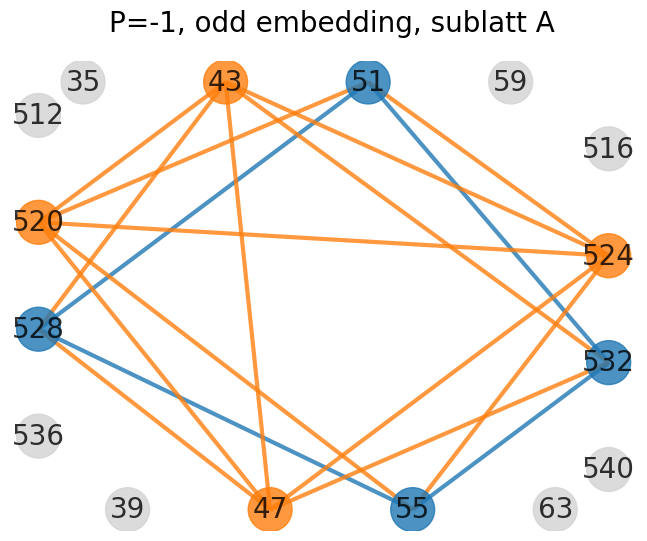

In [88]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent 

node_colors = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=-1, odd embedding, sublatt A", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [65]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = {}, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)


this is also more realiable: as can be seen below in the histogram.

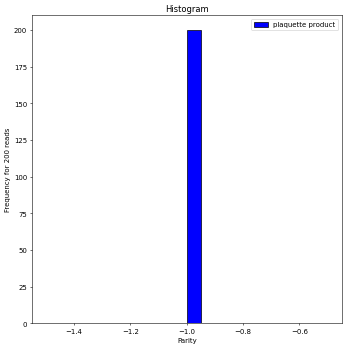

In [66]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



### Even parity encoding : Sublattice A

This version relies on one three chain and two single ancillas - it is a single unit-cell version of the Lechner gadget. 3 ancillas are needed for 4 qubits - one of the ancillas is realized as a 2-chain. 

In [82]:
edges_chain = [(51, 528)]
edges_dominant = [(55, 524), (520, 55), (51, 55), (528, 532), (43, 532), (47, 532)]
edges_intra = [(520, 51), (520, 524), (43, 528), (524, 51), (43, 47), (528, 47)]

ancilla_sites = [532, 55]
ancilla_sites_chain = [51, 528]
qubit_sites = [520, 43, 47, 524]

all_edges = edges_chain + edges_dominant + edges_intra 
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -4
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        h_dict.update({i:-2})
    elif i in ancilla_sites_chain:
        h_dict.update({i:-1})
    elif i in qubit_sites:
        h_dict.update({i:-1})

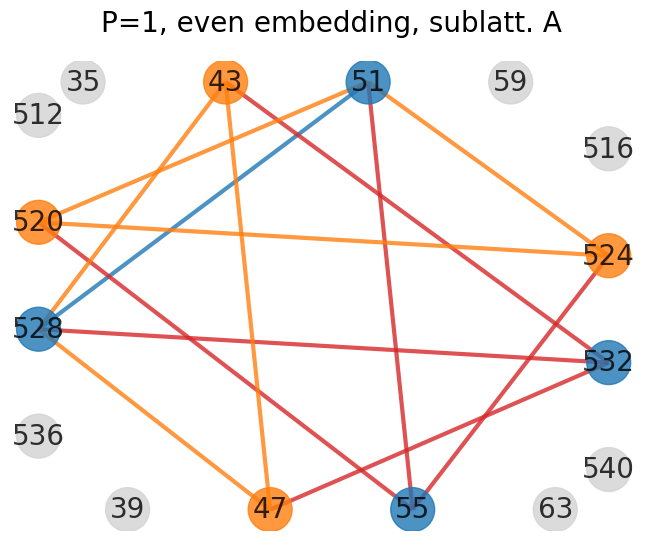

In [84]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    elif ed in edges_dominant or Reverse(ed) in edges_dominant:
        edge_colors.append(all_colors[3])
    else:
        edge_colors.append(all_colors[1])

absent = [512, 536, 35, 59, 540, 516, 39, 63]
res_v2 = res + absent 

node_colors = []
for site in res_v2:
    if site in qubit_sites:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=1, even embedding, sublatt. A", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [91]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)

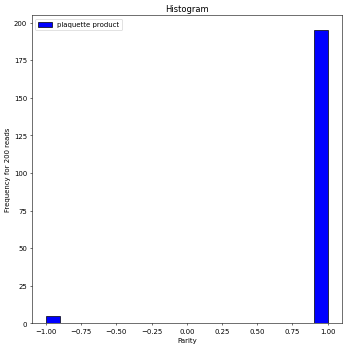

In [92]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
for j in qubit_sites:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# Sublattice B embeddings

#### Odd parity embedding : sublattice B


In [91]:
edges_chain = [(59, 516), (63, 516), (512, 63), (512, 59)]
edges_dominant = [(43, 516), (43, 512),(59, 520), (59, 524), (47, 512), (47, 516), (63, 520), (63,524)]
edges_intra = [(43,520), (43,524), (520,47), (524, 47)]
edges_diagonal = [(43, 47), (520,524)]

all_edges = edges_chain + edges_dominant + edges_intra + edges_diagonal
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_diagonal:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

Return the simplified graph of the embedding

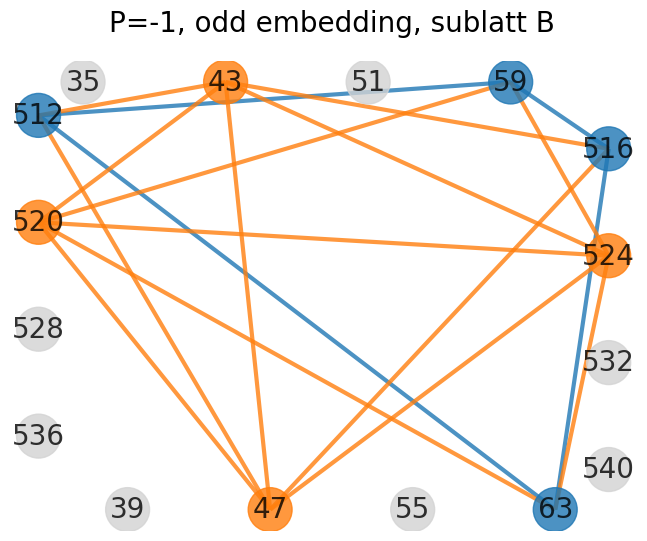

In [92]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    else:
        edge_colors.append(all_colors[1])

absent = [528, 536, 35, 51, 532, 540, 55, 39]
res_v2 = res + absent 

node_colors = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for site in res_v2:
    if site in qubits_measure:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=-1, odd embedding, sublatt B", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [70]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = {}, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)


Serving Inspector on http://127.0.0.1:18000/?problemId=81cbf442-87e8-4525-9318-4fbdc5538edb

this is also more realiable: as can be seen below in the histogram.

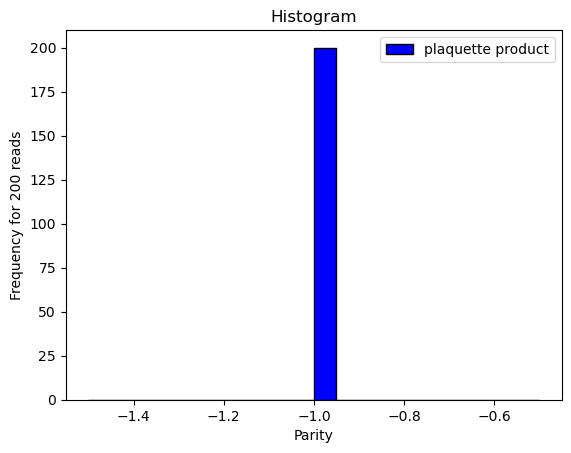

In [67]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
qubits_measure =  [520, 43, 47, 524] #majority rule
for j in qubits_measure:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



### Even parity encoding : Sublattice B

In [85]:
edges_chain = [(59, 512)]
edges_dominant = [(63, 524), (520, 63), (59, 63), (512, 516), (43, 516), (47, 516)]
edges_intra = [(520, 59), (520, 524), (43, 512), (524, 59), (43, 47), (512, 47)]

ancilla_sites = [516, 63]
ancilla_sites_chain = [59, 512]
qubit_sites = [520, 43, 47, 524]

all_edges = edges_chain + edges_dominant + edges_intra 
J_dict = {}
for e in all_edges:
    if e in edges_chain:
        jval = -4
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_dominant:
        jval = 2
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)
    elif e in edges_intra:
        jval = 1
        if e in sampler.edgelist:
            J_dict.update({e:jval})
        elif Reverse(e) in sampler.edgelist:
            J_dict.update({Reverse(e):jval})
        else:
            print("problem with ", e)

all_sites = ancilla_sites + qubit_sites
h_dict = {}
for i in all_sites:
    if i in ancilla_sites:
        h_dict.update({i:-2})
    elif i in ancilla_sites_chain:
        h_dict.update({i:-1})
    elif i in qubit_sites:
        h_dict.update({i:-1})

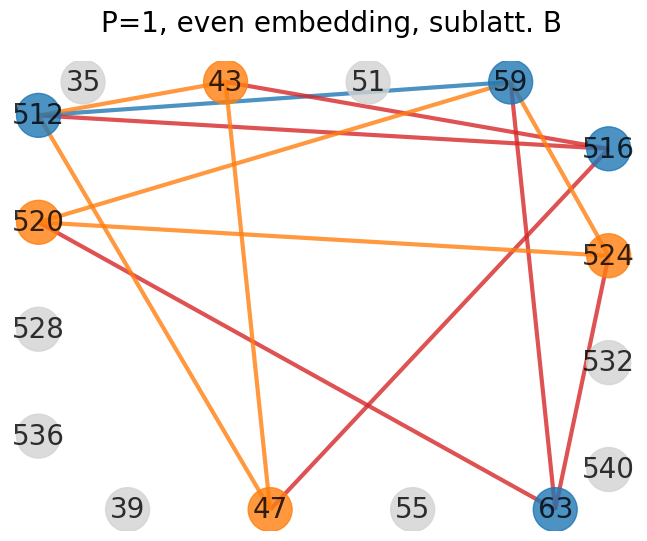

In [86]:
sites = []
for ed in all_edges:
    sites.append(ed[0])
    sites.append(ed[1])
res = [*set(sites)]
#print(res)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if ed in edges_chain or Reverse(ed) in edges_chain:
        edge_colors.append(all_colors[0])
    elif ed in edges_dominant or Reverse(ed) in edges_dominant:
        edge_colors.append(all_colors[3])
    else:
        edge_colors.append(all_colors[1])

absent = [528, 536, 35, 51, 540, 532, 39, 55]
res_v2 = res + absent 

node_colors = []
for site in res_v2:
    if site in qubit_sites:
        node_colors.append(all_colors[1])
    elif site in absent:
        node_colors.append('#D3D3D3')
    else:
        node_colors.append(all_colors[0])

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("P=1, even embedding, sublatt. B", x=0.5, y=1.2, fontsize = 20)
dnx.draw_zephyr(G, nodelist = res_v2, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

In [ ]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 200
    response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw", num_spin_reversal_transforms = 10)

    #dwave.inspector.show(response)

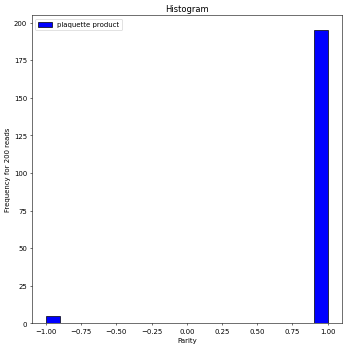

In [ ]:
#the index of the plaquette qubit
inds_qb_plaquettes = []
for j in qubit_sites:
    inds_qb_plaquettes.append(response.variables.index(j))

plaq_values = []
for resp in response.record:
    plaq_values.append(np.prod(resp[0][inds_qb_plaquettes]))
#plaq_values

# Create histogram
plt.hist(np.array(plaq_values), bins=20, edgecolor='black', color = 'blue', label = 'plaquette product')

# Customize labels and title
plt.xlabel('Parity')
plt.ylabel('Frequency for 200 reads')
plt.title('Histogram')
plt.legend()
# Display the histogram
plt.show()



# Stitching it all together:


### Firstly, a function that does any embedding

In [129]:
def plaquette_embedding(sublatt, parity, corner_top_left_indices, tuple_shift):
    top_left_vertical = corner_top_left_indices[0]
    top_left_horizontal = corner_top_left_indices[1]
    shift_x = tuple_shift[0]
    shift_y = tuple_shift[1]

    plaquette_sites = [top_left_horizontal + 8, top_left_vertical + shift_x + 8, top_left_horizontal + 8 + shift_y, top_left_vertical + 8]
    ancilla_sites_B = [top_left_horizontal + 24, top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y, top_left_vertical]
    ancilla_sites_A = [top_left_horizontal + 16, top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y, top_left_vertical + 16]
    J_dict = {}
    h_dict = {}
    missing_coupler = {}
    missing_qubits = {}

    J_couplers_even = [-4, 2, 1]
    J_couplers_odd = [-2,1, 1]

    if sublatt == 'A':
        ancilla_sites = ancilla_sites_A
        all_sites = ancilla_sites + plaquette_sites
        if parity == 1:
            chain_sites = [top_left_horizontal + 16, top_left_vertical + 16]
            #even embedding
            edges_chain = [(top_left_horizontal + 16, top_left_vertical + 16)]
            edges_dominant = [(top_left_horizontal + 16 + shift_y, top_left_horizontal + 16), 
            (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
            (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
            (top_left_vertical + shift_x + 16, top_left_horizontal + 8),
            (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
            (top_left_vertical + shift_x + 16, top_left_vertical + 16)]
            edges_intra = [(top_left_horizontal + 16, top_left_vertical + shift_x + 8),
             (top_left_vertical + shift_x + 8, top_left_vertical + 8),
             (top_left_vertical + 8, top_left_horizontal + 16),
             (top_left_vertical + 16, top_left_horizontal + 8),
             (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
             (top_left_horizontal + 8 + shift_y, top_left_vertical + 16)]

            all_edges = edges_chain + edges_dominant + edges_intra 
            for e in all_edges:
                if e in edges_chain:
                    jval = J_couplers_even[0]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_dominant:
                    jval = J_couplers_even[1]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_intra:
                    jval = J_couplers_even[2]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})

            for i in all_sites:
                if i in ancilla_sites:
                    if i in chain_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
                    else:
                        if i in sampler.nodelist:
                            h_dict.update({i:-2})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-2})
                elif i in plaquette_sites:
                    if i in sampler.nodelist:
                        h_dict.update({i:-1})
                    else:
                        #print("problem with ", i)
                        missing_qubits.update({i:-1})
        elif parity == -1:
            #even embedding
            edges_chain = [(top_left_horizontal + 16, top_left_vertical + shift_x + 16), 
            (top_left_vertical + shift_x + 16, top_left_horizontal + 16 + shift_y), 
            (top_left_horizontal + 16 + shift_y, top_left_vertical + 16),
            (top_left_vertical + 16, top_left_horizontal + 16)]
            edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
            (top_left_horizontal + 8, top_left_vertical + 8),
            (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
            (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
            (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
            (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

            edges_intra = [(top_left_horizontal + 16, top_left_vertical + 8 + shift_x),
            (top_left_horizontal + 16, top_left_vertical + 8), 
            (top_left_vertical + shift_x + 16, top_left_horizontal + 8), 
            (top_left_vertical + shift_x + 16, top_left_horizontal + 8 + shift_y),
            (top_left_horizontal + 16 + shift_y, top_left_vertical + shift_x + 8), 
            (top_left_horizontal + 16 + shift_y, top_left_vertical + 8),
            (top_left_vertical + 16, top_left_horizontal + 8),
            (top_left_vertical + 16, top_left_horizontal + 8 + shift_y)]

            all_edges = edges_chain + edges_intra + edges_inter
            for e in all_edges:
                if e in edges_chain:
                    jval = J_couplers_odd[0]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_intra:
                    jval = J_couplers_odd[1]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_inter:
                    jval = J_couplers_odd[2]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})

            for i in all_sites:
                if i not in sampler.nodelist:
                    #print("problem with ", i)
                    missing_qubits.update({i:0})
    elif sublatt == 'B':
        ancilla_sites = ancilla_sites_B
        all_sites = ancilla_sites + plaquette_sites
        if parity == 1:
            chain_sites = [top_left_horizontal + 24, top_left_vertical]
            #even embedding
            edges_chain = [(top_left_horizontal + 24, top_left_vertical)]
            edges_dominant = [(top_left_horizontal + 24 + shift_y, top_left_horizontal + 24), 
            (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
            (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
            (top_left_vertical + shift_x, top_left_horizontal + 8),
            (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
            (top_left_vertical + shift_x, top_left_vertical)]
            edges_intra = [(top_left_horizontal + 24, top_left_vertical + shift_x + 8),
             (top_left_vertical + shift_x + 8, top_left_vertical + 8),
             (top_left_vertical + 8, top_left_horizontal + 24),
             (top_left_vertical, top_left_horizontal + 8),
             (top_left_horizontal + 8, top_left_horizontal + 8 + shift_y),
             (top_left_horizontal + 8 + shift_y, top_left_vertical)]

            all_edges = edges_chain + edges_dominant + edges_intra 
            for e in all_edges:
                if e in edges_chain:
                    jval = J_couplers_even[0]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_dominant:
                    jval = J_couplers_even[1]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_intra:
                    jval = J_couplers_even[2]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})

            for i in all_sites:
                if i in ancilla_sites:
                    if i in chain_sites:
                        if i in sampler.nodelist:
                            h_dict.update({i:-1})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-1})
                    else:
                        if i in sampler.nodelist:
                            h_dict.update({i:-2})
                        else:
                            #print("problem with ", i)
                            missing_qubits.update({i:-2})
                elif i in plaquette_sites:
                    if i in sampler.nodelist:
                        h_dict.update({i:-1})
                    else:
                        #print("problem with ", i)
                        missing_qubits.update({i:-1})
        elif parity == -1:
            #even embedding
            edges_chain = [(top_left_horizontal + 24, top_left_vertical + shift_x), 
            (top_left_vertical + shift_x, top_left_horizontal + 24 + shift_y), 
            (top_left_horizontal + 24 + shift_y, top_left_vertical),
            (top_left_vertical, top_left_horizontal + 24)]
            edges_inter = [(top_left_horizontal + 8, top_left_vertical + shift_x + 8),
            (top_left_horizontal + 8, top_left_vertical + 8),
            (top_left_horizontal + 8 + shift_y, top_left_vertical + 8 + shift_x),
            (top_left_horizontal + 8 + shift_y, top_left_vertical + 8), 
            (top_left_horizontal + 8 + shift_y, top_left_horizontal + 8), 
            (top_left_vertical + 8 + shift_x, top_left_vertical + 8)]

            edges_intra = [(top_left_horizontal + 24, top_left_vertical + 8 + shift_x),
            (top_left_horizontal + 24, top_left_vertical + 8), 
            (top_left_vertical + shift_x, top_left_horizontal + 8), 
            (top_left_vertical + shift_x, top_left_horizontal + 8 + shift_y),
            (top_left_horizontal + 24 + shift_y, top_left_vertical + shift_x + 8), 
            (top_left_horizontal + 24 + shift_y, top_left_vertical + 8),
            (top_left_vertical, top_left_horizontal + 8),
            (top_left_vertical, top_left_horizontal + 8 + shift_y)]

            all_edges = edges_chain + edges_intra + edges_inter
            for e in all_edges:
                if e in edges_chain:
                    jval = J_couplers_odd[0]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_intra:
                    jval = J_couplers_odd[1]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
                elif e in edges_inter:
                    jval = J_couplers_odd[2]
                    if e in sampler.edgelist:
                        J_dict.update({e:jval})
                    elif Reverse(e) in sampler.edgelist:
                        J_dict.update({Reverse(e):jval})
                    else:
                        #print("problem with ", e)
                        missing_coupler.update({e:jval})
            
            for i in all_sites:
                if i not in sampler.nodelist:
                    #print("problem with ", i)
                    missing_qubits.update({i:0})

    return h_dict, J_dict, plaquette_sites, ancilla_sites, missing_coupler, missing_qubits


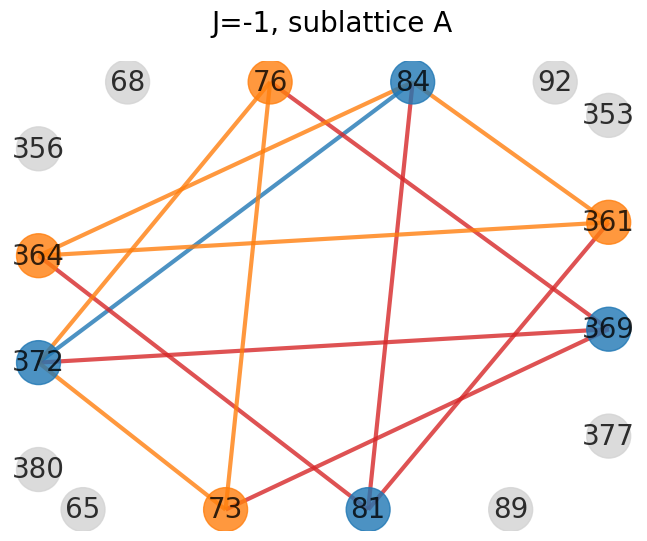

In [111]:
#for a given starting point

J_box = -1
sublattice = 'A'
corner_indices = (356, 68)
shift_x = -3
shift_y = -3
h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub = plaquette_embedding(sublattice, -1*J_box, corner_indices, (shift_x, shift_y))

#these are all the qubits present in this plaquette
all_plot_qubits = []
for i in range(4):
    all_plot_qubits.append(corner_indices[0] + 8*i)
    all_plot_qubits.append(corner_indices[0] + 8*i + shift_y)
    all_plot_qubits.append(corner_indices[1] + 8*i)
    all_plot_qubits.append(corner_indices[1] + 8*i + shift_x)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if J_dict[ed] < 0:
        edge_colors.append(all_colors[0])
    elif J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

node_colors = []
for site in all_plot_qubits:
    if site in plaquette:
        node_colors.append(all_colors[1])
    elif site in ancillas:
        node_colors.append(all_colors[0])
    else:
        node_colors.append('#D3D3D3')

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("J={}, sublattice ".format(J_box) + sublattice, x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

Cell to obtain the checkboard array of A and B cells and of shifts in the X and Y directions

In [77]:
#array of A,B and the x and y shifts
Lx = 7; Ly = 7; #this is the max that can be done. 
#this is the plaquette values
array_AB = [['' for i in range(Ly)] for j in range(Lx)]
array_shifts = np.empty((Lx, Ly,2))
for ix in range(Lx):
    for iy in range(Ly):
        if ix%2 == 0:
            if iy%2 == 0:
                array_AB[ix][iy] = 'A'
            else:
                array_AB[ix][iy] = 'B'
        else:
            if iy%2 == 0:
                array_AB[ix][iy] = 'B'
            else:
                array_AB[ix][iy] = 'A'
        
        array_shifts[ix, iy] = [4 - (ix%2)*7,4 - (iy%2)*7]

array_AB = np.array(array_AB)


Then, a small cell for obtaining the starting numbers (top left corner) of any cell at a given translation vector

In [69]:
translation_vector = [2,3] #
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
cell_shifts = []
for i in range(4):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
print(starting_tuple)

[417 101]


putting all the single cell work together: now, only specify the first line (translation vector)

missing couplers
{}
missing qubits
{}


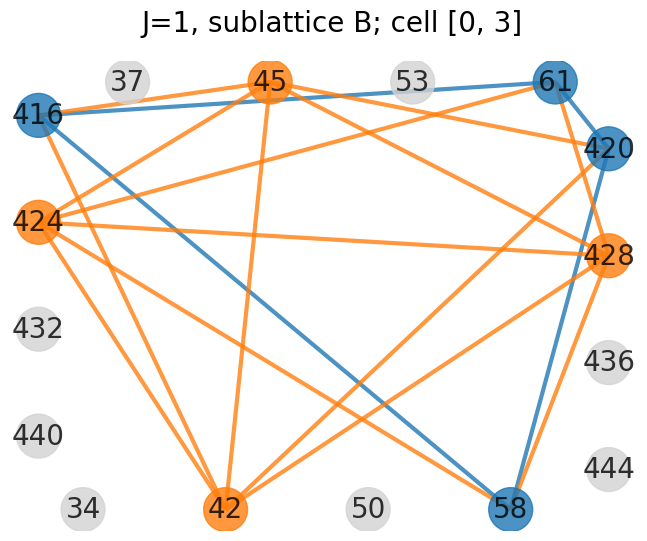

In [113]:
translation_vector = [0,3] #
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
cell_shifts = []
for i in range(5):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
#print(starting_tuple)

J_box = 1
sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
#print(sublattice)
shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
#print(shift_x, shift_y)
h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))

print("missing couplers")
print(missing_coup)
print("missing qubits")
print(missing_qub)

#these are all the qubits present in this plaquette
all_plot_qubits = []
for p in range(4):
    all_plot_qubits.append(starting_tuple[0] + 8*p)
    all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
    all_plot_qubits.append(starting_tuple[1] + 8*p)
    all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)

all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
edges_draw = [key for key in J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if J_dict[ed] < 0:
        edge_colors.append(all_colors[0])
    elif J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

node_colors = []
for site in all_plot_qubits:
    if site in plaquette:
        node_colors.append(all_colors[1])
    elif site in ancillas:
        node_colors.append(all_colors[0])
    else:
        node_colors.append('#D3D3D3')

G = dnx.zephyr_graph(4)
plt.ion()
plt.axis("off")
plt.title("J={}, sublattice ".format(J_box) + sublattice + "; cell {}".format(translation_vector), x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8, edge_color = edge_colors)

# Tiling for a random $J_{\Box}$ configuration

We now tile the checkerboard lattice with those patterns and create our final embedding. Note that missing qubits and missing couplers are **not** fixed.

In [244]:
#J grid
#all ones or minus ones
Lx = 7; Ly = 7;
jbox_values = np.ones((Lx,Ly))
#jbox_values = 1 - 2*np.random.randint(0, 2, (Lx, Ly))
base_tuple = np.array([320, 32])
cell_shifts_unit = np.array([0,4])
cell_shifts = []
for i in range(5):
    cell_shifts.append(cell_shifts_unit + i*np.ones(2, dtype = np.int8))
cell_shifts = np.array(cell_shifts).flatten()

complete_h_dict = {}
complete_J_dict = {}
plaquette_by_plaquette = {}
missing_coup_all = []
missing_qub_all = []
all_plaquettes = []
all_ancillas = []
list_all_missing_qub = []
all_plot_qubits = []

for ix in range(Lx):
    for iy in range(Ly):
        translation_vector = [ix,iy] #
        starting_tuple = base_tuple + np.array([32*translation_vector[1] + cell_shifts[translation_vector[0]], 32*translation_vector[0] + cell_shifts[translation_vector[1]]])
        print("cell:", starting_tuple)

        J_box = jbox_values[ix,iy]
        sublattice = str(array_AB[translation_vector[0], translation_vector[1]])
        #print(sublattice)
        shift_x = int(array_shifts[translation_vector[0], translation_vector[1], 0])
        shift_y = int(array_shifts[translation_vector[0], translation_vector[1], 1])
        #print(shift_x, shift_y)
        h_dict, J_dict, plaquette, ancillas, missing_coup, missing_qub  = plaquette_embedding(sublattice, -1*J_box, starting_tuple, (shift_x, shift_y))

        plaquette_by_plaquette.update({tuple(translation_vector):plaquette})
        all_plaquettes.append(plaquette)
        all_ancillas.append(ancillas)
        missing_coup_all.append(missing_coup)
        missing_qub_all.append(missing_qub)
        for node in list(missing_qub):
            list_all_missing_qub.append(node)

        #J_dict is simply updated, it never interferes with itself
        complete_J_dict.update(J_dict)
        #h_dict has to be added to each h if there is doubling
        for key in h_dict.keys():
            if key in complete_h_dict:
                complete_h_dict[key] += h_dict[key]
            else:
                complete_h_dict.update({key:h_dict[key]})

        print("missing couplers")
        print(missing_coup)
        print("missing qubits")
        print(missing_qub)

        for p in range(4):
            all_plot_qubits.append(starting_tuple[0] + 8*p)
            all_plot_qubits.append(starting_tuple[0] + 8*p + shift_x)
            all_plot_qubits.append(starting_tuple[1] + 8*p)
            all_plot_qubits.append(starting_tuple[1] + 8*p + shift_y)


cell: [320  32]
missing couplers
{(48, 328): 1, (52, 328): 1, (40, 328): 1, (44, 328): 1, (332, 328): 1}
missing qubits
{328: 0}
cell: [352  36]
missing couplers
{}
missing qubits
{}
cell: [384  33]
missing couplers
{(404, 45): 1}
missing qubits
{}
cell: [416  37]
missing couplers
{}
missing qubits
{}
cell: [448  34]
missing couplers
{}
missing qubits
{}
cell: [480  38]
missing couplers
{}
missing qubits
{}
cell: [512  35]
missing couplers
{}
missing qubits
{}
cell: [324  64]
missing couplers
{}
missing qubits
{}
cell: [356  68]
missing couplers
{}
missing qubits
{}
cell: [388  65]
missing couplers
{}
missing qubits
{}
cell: [420  69]
missing couplers
{(82, 436): -2, (436, 85): -2, (436, 77): 1, (436, 74): 1}
missing qubits
{436: 0}
cell: [452  66]
missing couplers
{}
missing qubits
{}
cell: [484  70]
missing couplers
{(83, 500): -2}
missing qubits
{}
cell: [516  67]
missing couplers
{}
missing qubits
{}
cell: [321  96]
missing couplers
{}
missing qubits
{}
cell: [353 100]
missing coup

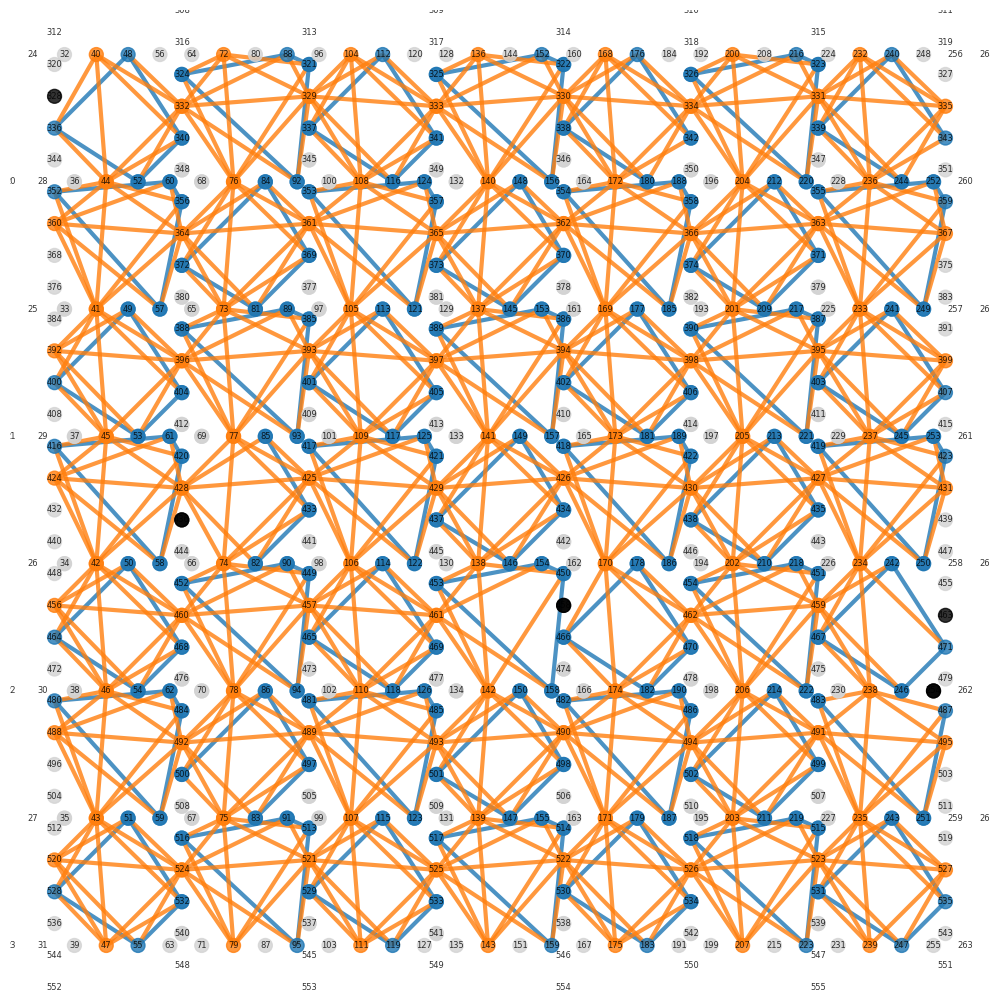

In [245]:
edges_draw = [key for key in complete_J_dict.keys()]
edge_colors = []
for ed in edges_draw:
    if complete_J_dict[ed] < 0:
        edge_colors.append(all_colors[0])
    elif complete_J_dict[ed] == 1:
        edge_colors.append(all_colors[1])
    elif complete_J_dict[ed] == 2:
        edge_colors.append(all_colors[3])

node_colors = []
all_ancillas = np.array(all_ancillas).flatten()
all_plaquettes = np.array(all_plaquettes).flatten()
list_all_missing_qub = np.array(list_all_missing_qub).flatten()
for site in all_plot_qubits:
    if site in all_plaquettes:
        color = all_colors[1]
    elif site in all_ancillas:
        color = all_colors[0]
    else:
        color = '#D3D3D3'
    
    if site in list_all_missing_qub:
        color = '#000000'
        
    node_colors.append(color)

G = dnx.zephyr_graph(4)
plt.ion()
fig = plt.figure(figsize=(10,10))
plt.axis("off")
#plt.title("J={}, sublattice ".format(J_box) + sublattice + "; cell {}".format(translation_vector), x=0.5, y=1.2, fontsize = 20)
#dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 1000, quadratic_biases = J_dict, with_labels = True, node_color = node_colors, font_size = 20, alpha = 0.8)
dnx.draw_zephyr(G, nodelist = all_plot_qubits, width = 3, node_size = 100, edgelist = edges_draw, with_labels = True, node_color = node_colors, font_size = 6, alpha = 0.8, edge_color = edge_colors)

In [246]:
#run it
run_true_or_false = True
if run_true_or_false:
    num_reads = 2000
    response = sampler.sample_ising(h = complete_h_dict, J=complete_J_dict,
                                                num_reads=num_reads,
                                                annealing_time=100,
                                                answer_mode="raw")

    #dwave.inspector.show(response)

In [252]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=a5fbec3c-4275-46f9-92ce-fba3873f38c8

'http://127.0.0.1:18000/?problemId=a5fbec3c-4275-46f9-92ce-fba3873f38c8'

extract the list of plaquettes and the indices in the variables of the response that the qubits correspond to

In [221]:
plaq_variable_index = []
for i in range(int(len(all_plaquettes)/4)):
    qubit_indices = all_plaquettes[4*i:(4*i+4)]
    single_plaquette = []
    for k in range(4):
        where_is_it = np.where(np.array(response.variables) == qubit_indices[k])[0]
        if len(where_is_it) > 0:
            single_plaquette.append(where_is_it[0])
    plaq_variable_index.append(np.array(single_plaquette))
print(plaq_variable_index)

[array([  0, 162,   4]), array([  4, 186,   1, 182]), array([  1, 206,   5, 202]), array([  5, 230,   2, 226]), array([  2, 248,   6, 245]), array([  6, 271,   3, 267]), array([  3, 291,   7, 287]), array([ 22, 159,  26, 162]), array([ 26, 183,  23, 186]), array([ 23, 203,  27, 206]), array([ 27, 227,  24, 230]), array([ 24, 246,  28, 248]), array([ 28, 268,  25, 271]), array([ 25, 288,  29, 291]), array([ 44, 163,  48, 159]), array([ 48, 187,  45, 183]), array([ 45, 207,  49, 203]), array([ 49, 231,  46, 227]), array([ 46, 249,  50, 246]), array([ 50, 272,  47, 268]), array([ 47, 292,  51, 288]), array([ 66, 160,  70, 163]), array([ 70, 184,  67, 187]), array([ 67, 204,  71, 207]), array([ 71, 228,  68, 231]), array([ 68,  72, 249]), array([ 72, 269,  69, 272]), array([ 69, 289,  73, 292]), array([ 88, 164,  92, 160]), array([ 92, 188,  89, 184]), array([ 89, 208,  93, 204]), array([ 93, 232,  90, 228]), array([ 90, 250,  94]), array([ 94, 273,  91, 269]), array([ 91, 293,  95, 289]),

In [271]:
values = []
values_min = []
#find minimum energy
min_ene = response.record[0][1]
count = 0

for resp in response.record:
    current_value = 0
    for k in range(len(plaq_variable_index)):
        current_value += np.prod(resp[0][plaq_variable_index[k]])
    values.append(current_value)
    if resp[1] == min_ene:
        count += 1
        values_min.append(current_value)

print("number of samples in lowest energy state: ", count/len(response.record))
print("avg value of Sum(P)/N for the lowest energy states: ", np.mean(values_min)/(7*7))
print("avg value of Sum(P)/N for all states: ", np.mean(values)/(7*7))

number of samples in lowest energy state:  0.714
avg value of Sum(P)/N for the lowest energy states:  -0.9011890470473904
avg value of Sum(P)/N for all states:  -0.8925510204081633


Doing a real space average for each plaquette

In [254]:
#unit cells in the same order as the plaq_variable_index
unit_cell_after = [key for key in list(plaquette_by_plaquette)]
all_avg = np.zeros((Lx,Ly))
min_ene = response.record[0][1]
count = 0
for resp in response.record:
    if resp[1] == min_ene:
        count += 1
        for k in range(len(plaq_variable_index)):
            all_avg[unit_cell_after[k]] += np.prod(resp[0][plaq_variable_index[k]])
            current_value += np.prod(resp[0][plaq_variable_index[k]])

In [263]:
all_avg/count

array([[-0.11204482, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -0.30392157, -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        ,  0.01540616,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        ,  0.14845938,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -0.88515406,
        -0.0210084 , -1.        ]])

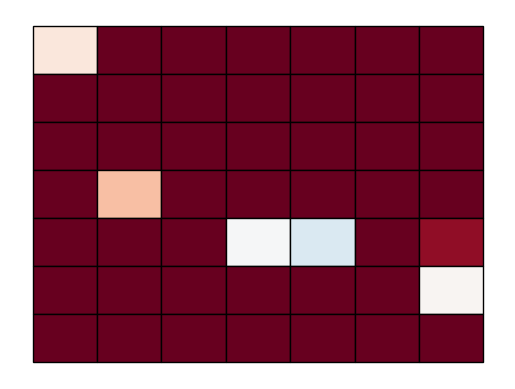

In [270]:
from matplotlib.pyplot import subplots
from matplotlib.table import Table
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
cmap = cm.get_cmap('RdBu')
#norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)

#this is the plaquette values
ary = np.transpose(all_avg/count)
#random_colors = np.random.randint(0, 2, (Lx, Ly))
#this is the individual qubit values (at nodes)
# node_values = np.random.randint(0, 2, (Lx+1, Ly+1))

# ybond_qubit = np.random.randint(0, 2, (Lx, Ly+1))
# xbond_qubit = np.random.randint(0, 2, (Lx+1, Ly))

cell_colors=("white", "black")
font_colors=("black", "white")
node_colors = ("red", "blue")
fmt="%.2f"
figsize=None
fontsize=None
show_text = False

fig, ax = subplots(figsize=figsize)
ax.set_axis_off()
delta = 1/11/2
tb = Table(ax, bbox = [delta, delta, 1 - 2*delta, 1-2*delta])

n_rows, n_cols = ary.shape
width, height = 1.0/(n_rows + 1) , 1.0/(n_cols + 1)
for (row_idx, col_idx), cell_val in np.ndenumerate(ary):
    idx = (col_idx + row_idx) % 2
    color_code = int(cell_val > 0.5)
    # if show_text:
    #     text_in = fmt % cell_val
    # else:
    #     text_in = ""
    tb.add_cell(
        row_idx,
        col_idx,
        width,
        height,
        #text=text_in,
        loc="center",
        facecolor=cmap((cell_val + 1)/2),
    )
    #print(cmap(cell_val))
    #tb._cells[(row_idx, col_idx)]._text.set_color(font_colors[color_code])

tb.set_fontsize(fontsize)
ax.add_table(tb)


make colorbar

/tmp/ipykernel_10928/2996533790.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


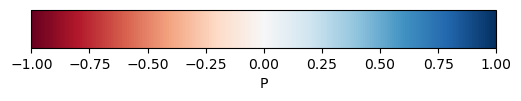

In [269]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = cm.get_cmap('RdBu')
norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('P')
fig.show()

# Things to help you plot - colors!

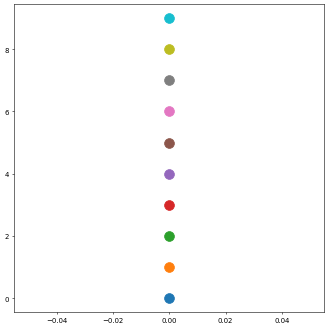

In [89]:
all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

count = 0
for i in range(len(all_colors)):
    plt.scatter([0], [count], color = all_colors[i], s=200)
    count += 1
